Calculate Kuiper metric for a given cadence for each point of the sky.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband
from KuiperMetric import KuiperVS
from datetime import datetime

In [3]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)

outDir = datetime.today().strftime('%d_%m_%Y_')+'tempFineMap'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [4]:
# Same for rolling cadence
rollDbFile = '/home/alex/rubin_sim_data/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db'
rollName = os.path.split(rollDbFile)[-1].replace('.db', '')
rollDb = maf.db.OpsimDatabase(rollDbFile)
resultsDbRoll = maf.db.ResultsDb(outDir=outDir)
print(rollName)

rolling_all_sky_ns2_rw0.9_v2.0_10yrs


In [5]:
# Set range of periods for which we're gonna build the maps
start=0.1
numPoints=500
totalObsLength=365*7

periods=np.round(np.geomspace(start,totalObsLength,numPoints),4)
bundleList=[]
bundleListRoll=[]
summary_metrics = [maf.MedianMetric()]
sql = ''
nside=2**6 # for HealpixSlicer
slicer = maf.HealpixSlicer(nside=nside)
for p in periods:
    metric = KuiperVS(period=p)
    
    bundleList.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_metrics, 
                                       runName='KuiperMedian_'+str(p)))
    bundleListRoll.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_metrics, 
                                           runName='RollKuiperMedian_'+str(p)))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [6]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with no constraint for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos'].
Found 2086980 visits
Running:  ['KuiperMedian_0_1_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1021_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1042_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1063_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1085_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1107_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_113_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1153_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1177_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1201_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1226_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1251_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1276_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1303_KuiperVS_observationStartMJD_HEAL', 'KuiperMedian_0_1329_KuiperVS_observationStartMJD_H

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
bdRoll = maf.metricBundles.makeBundlesDictFromList(bundleListRoll)
bgRoll = maf.metricBundles.MetricBundleGroup(bdRoll, rollDb, outDir=outDir, resultsDb=resultsDbRoll)
bgRoll.runAll()

Querying database observations with no constraint for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos'].
Found 2088105 visits
Running:  ['RollKuiperMedian_0_1_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1021_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1042_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1063_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1085_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1107_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_113_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1153_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1177_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1201_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1226_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1251_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1276_KuiperVS_observationStartMJD_HEAL', 'RollKuiperMedian_0_1303_KuiperVS_observationStartMJD_HE

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
getMedianDict=lambda bList:[(float(p.runName.split('_')[1]),round(p.summaryValues['Median'],3)) for p in bList]
periods=pd.DataFrame(columns=['period','median Kuiper value'],data=getMedianDict(bundleList))
periodsRoll=pd.DataFrame(columns=['period','median Kuiper value'],data=getMedianDict(bundleListRoll))

Text(0, 0.5, 'Median Kuiper metric')

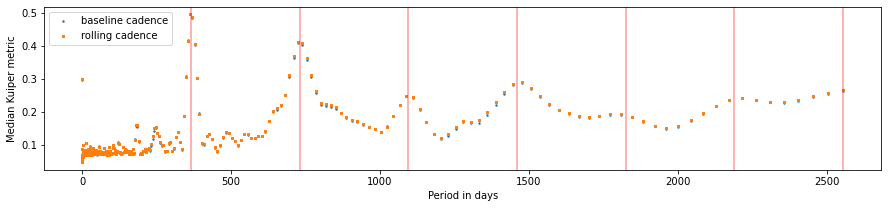

In [9]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.scatter(periods['period'],periods['median Kuiper value'],s=2,label='baseline cadence')
ax.scatter(periodsRoll['period'],periodsRoll['median Kuiper value'],marker='s',s=2,label='rolling cadence')
i=0
while i<totalObsLength:
    i+=365
    ax.axvline(i,color='r',alpha=0.4)
ax.legend()
ax.set_xlabel('Period in days')
ax.set_ylabel('Median Kuiper metric')

(0.0, 0.316)

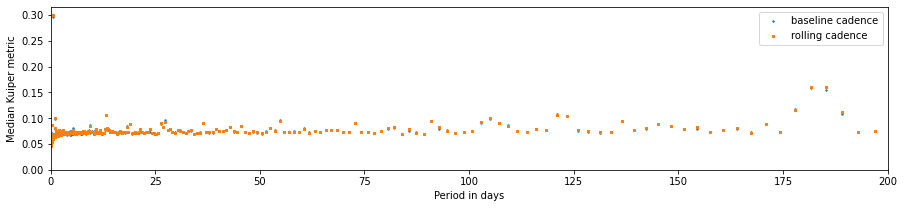

In [10]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.scatter(periods['period'],periods['median Kuiper value'],s=2,label='baseline cadence')
ax.scatter(periodsRoll['period'],periodsRoll['median Kuiper value'],marker='s',s=2,label='rolling cadence')
i=0
while i<totalObsLength:
    i+=365
    ax.axvline(i,color='r',alpha=0.4)
ax.legend()
ax.set_xlabel('Period in days')
ax.set_ylabel('Median Kuiper metric')
ax.set_xlim(0,200)
ax.set_ylim(0,max(list(periods['median Kuiper value'])[:200])+0.02)

(0.028, 0.117)

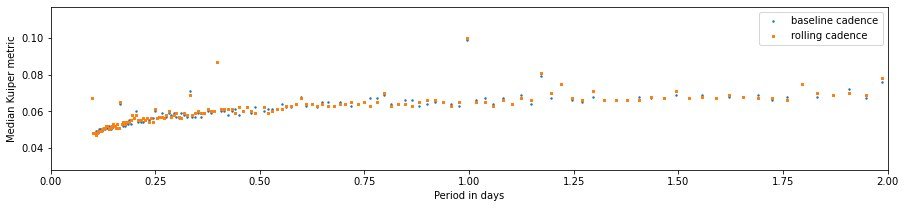

In [11]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.scatter(periods['period'],periods['median Kuiper value'],s=2,label='baseline cadence')
ax.scatter(periodsRoll['period'],periodsRoll['median Kuiper value'],marker='s',s=2,label='rolling cadence')
i=0
while i<totalObsLength:
    i+=365
    ax.axvline(i,color='r',alpha=0.4)
ax.legend()
ax.set_xlabel('Period in days')
ax.set_ylabel('Median Kuiper metric')
ax.set_xlim(0,2)
ax.set_ylim(min(list(periods['median Kuiper value'])[:2])-0.02,max(list(periods['median Kuiper value'])[:2])+0.05)

In [13]:
cadenceComparison=pd.DataFrame(columns=['period min','period max',
                                        'baseline median Kuiper','rolling median Kuiper'])


d={'period min':0.1,'period max':1,
      'baseline median Kuiper':periods[(periods['period']>0.1) & 
                                    (periods['period']<=1)]['median Kuiper value'].median().round(3),
      'rolling median Kuiper':periodsRoll[(periodsRoll['period']>0.1) & 
                                    (periodsRoll['period']<=1)]['median Kuiper value'].median().round(3)}
cadenceComparison=cadenceComparison.append(d,ignore_index=True)

for i in range(1,totalObsLength,365):
    d={'period min':i,'period max':i+365,
      'baseline median Kuiper':periods[(periods['period']>i) & 
                                    (periods['period']<=i+365)]['median Kuiper value'].median().round(3),
      'rolling median Kuiper':periodsRoll[(periodsRoll['period']>i) & 
                                    (periodsRoll['period']<=i+365)]['median Kuiper value'].median().round(3)}
    cadenceComparison=cadenceComparison.append(d,ignore_index=True)
cadenceComparison

,period min,period max,baseline median Kuiper,rolling median Kuiper
0,0.1,1.0,0.059,0.059
1,1.0,366.0,0.073,0.074
2,366.0,731.0,0.132,0.133
3,731.0,1096.0,0.203,0.206
4,1096.0,1461.0,0.168,0.172
5,1461.0,1826.0,0.193,0.196
6,1826.0,2191.0,0.172,0.174
7,2191.0,2556.0,0.238,0.239
